In [1]:
import brainpy as bp
import brainpy.math as bm
import numpy as np
import matplotlib.pyplot as plt
import scipy

import sys
sys.path.append('..')
from cann import CANN1D

seed = 123


/home/zilong/anaconda3/envs/hippocampalsequence/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1, simulate theta sweep

In [2]:
#set default ramndom seed for reproducibility
np.random.seed(seed)
#set backend to cpu
bm.set_platform('cpu')
#build and run the network
sweep_cann_1 = CANN1D(tau=1, tau_v=48., num=128, mbar=5.5, A=0.01)

v_ext = sweep_cann_1.a / 144 * 0.55   #animal speed
sweep_dur = 2.5*np.pi / v_ext              #duration of simulation
dt = bm.get_dt()                     #simulation time step                         
steps = int(sweep_dur / dt)                #steps of simulation

position = np.zeros(steps)
position[0] = -np.pi/3               #initial position
#generate position array
for i in range(steps)[1:]:
    position[i] = position[i - 1] + v_ext * dt
    if position[i] > np.pi:          #periodic boundary condition
        position[i] -= 2 * np.pi

position = position.reshape((-1, 1)) #reshape to (steps, 1) array to fit the input shape

noise = 0.001*np.random.randn(steps,sweep_cann_1.num) #add independent noise to the input with level 0.01

#generate series of external input bump
Iext = sweep_cann_1.get_stimulus_by_pos(position) + noise

#simulate the network
sweep_runner_1 = bp.DSRunner(sweep_cann_1,
                     inputs=('input', Iext, 'iter'),
                     monitors=['u', 'v', 'r','center','centerI'])
sweep_runner_1.run(sweep_dur)

Predict 51407 steps: : 100%|██████████| 51407/51407 [00:00<00:00, 58312.51it/s]


### 2 visualize

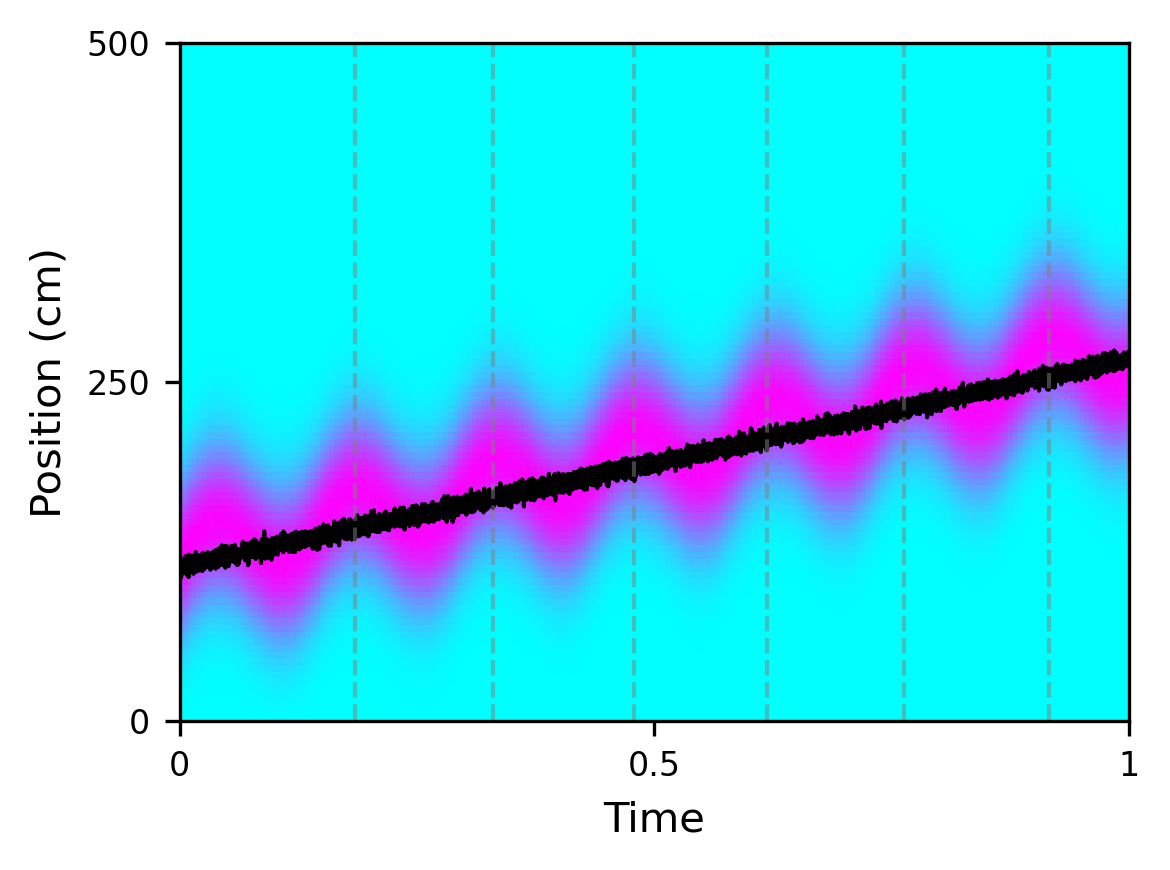

In [12]:
#make two subplots
fig, axs = plt.subplots(1, 1, figsize=(4, 3), dpi=300)
#set font size
labelsize = 10
ticksize = 8

########
#plot 1#
########

#visualize bump sweeps for 1 second. Cut the middle 1 second to avoid transient at the boundary
time = np.linspace(0, sweep_dur, steps)    #time array
time_start = int(1.9*bm.pi / v_ext/ dt)
time_end = int(2.9*bm.pi / v_ext/ dt)
time_slice=time[time_start:time_end]
#subtract time 0 from time_slice
time_slice = time_slice - time_slice[0]

pos = np.linspace(-np.pi,np.pi,sweep_cann_1.num+1)[0:-1]
fr = sweep_runner_1.mon.r.T[:,time_start:time_end]
cI = sweep_runner_1.mon.centerI[time_start:time_end]

##Theta oscillations
relative_pos = sweep_runner_1.mon.center[time_start:time_end] - sweep_runner_1.mon.centerI[time_start:time_end]
relative_pos = bm.where(relative_pos > np.pi, relative_pos - 2*np.pi,  relative_pos)
relative_pos = bm.where(relative_pos < -np.pi, relative_pos + 2*np.pi,  relative_pos)
relative_pos = np.squeeze(relative_pos)
Peaks,_ = scipy.signal.find_peaks(relative_pos, width=300)

c = axs.pcolormesh(time_slice[0:-1:50], pos, fr[:,0:-1:50]*1e3, cmap='cool')
#add animal position to the plot
axs.plot(time_slice, cI, color='black', linewidth=1, alpha=1.0)

#add separate lines to theta sweeps
for peaks in Peaks:
    axs.plot([time_slice[peaks], time_slice[peaks]],[-np.pi,np.pi],color='grey',linewidth=1, linestyle='--', alpha=0.5)

#set xlim and ylim
axs.set_xlim([0, 1e3])
axs.set_ylim([-2.5,2.5])
#set x and y labels
#axs[0,0].set_xlabel('Time (s)', fontsize=labelsize)
axs.set_ylabel('Position (cm)', fontsize=labelsize)
# set x and y ticks
xticks = np.linspace(0, 1e3, 3)
yticks = np.linspace(-2.5,2.5,3)
#set tick labels
xticklabels = [0, 0.5, 1]
yticklabels = [0, int(2.5*100), int(5*100)]

axs.set_xticks(xticks)
axs.set_yticks(yticks)
axs.set_xticklabels(xticklabels, fontsize=ticksize)
axs.set_yticklabels(yticklabels, fontsize=ticksize)

axs.set_xlabel('Time', fontsize=labelsize)

axs.tick_params(axis='x', labelsize=ticksize)
axs.tick_params(axis='y', labelsize=ticksize)

plt.tight_layout()

plt.savefig('./sweep_1DCAN.pdf', dpi=300)

